In [1]:
import pandas as pd
from IPython.display import display

df_main = pd.read_csv("hf://datasets/AbdulHadi806/mail_spam_ham_dataset/mail_data.csv")
df_email = pd.read_json("hf://datasets/SetFit/enron_spam/test.jsonl", lines=True)
df_email.pop("message_id")
df_synth = pd.read_csv("SyntheticMessages.csv", index_col=0)

In [2]:
df_main.Category = df_main.Category.map({"spam": 1, "ham": 0})

df_email = df_email.loc[:, ["message", "label"]]
df_email.rename(columns={"message": "Message", "label": "Category"}, inplace=True)

df_synth.rename(columns={"message": "Message"}, inplace=True)
df_synth.dropna(inplace=True)
df_synth.loc[:, "Category"] = None

In [3]:
df_main.drop_duplicates(inplace=True)
df_email.drop_duplicates(inplace=True)
df_synth.drop_duplicates(inplace=True)

In [4]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
)
# MAIN: cohen_kappa_score

In [5]:
df_main["source"] = "main"
df_email["source"] = "email"
df_synth["source"] = "synth"

In [6]:
df_all = pd.concat((df_main, df_email, df_synth), axis=0)
df_all = df_all.loc[df_all.Message.str.len() > 3, :]

In [7]:
from sklearn.model_selection import train_test_split


df_main = df_all.loc[df_all.source == "main"]
df_email = df_all.loc[df_all.source == "email"]
df_synth = df_all.loc[df_all.source == "synth"]


df_main_train, data_val = train_test_split(
    df_main, test_size=0.3,
    stratify=df_main.Category,
    random_state=42
)

In [8]:
data_train = pd.concat((df_main_train, df_email, df_synth), axis=0)

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
def process_text(s):
    return re.sub(r"[\!\"\#\$\%\&\\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\]\^\_\`\{\|\}\~]", "", s.lower())

data_train.Message = data_train.Message.apply(process_text)
data_val.Message = data_val.Message.apply(process_text)

[nltk_data] Downloading package stopwords to /home/vfyas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tf_idf_vec = TfidfVectorizer(min_df=15, stop_words=stopwords.words()).fit(data_train.Message)
bow_vec = CountVectorizer(min_df=15, stop_words=stopwords.words()).fit(data_train.Message)

y_train = data_train.loc[:, "Category"]
y_val = data_val.loc[:, "Category"].astype(int)

TF_train = tf_idf_vec.transform(data_train.Message).toarray()
BOW_train = bow_vec.transform(data_train.Message).toarray()

TF_val = tf_idf_vec.transform(data_val.Message).toarray()
BOW_val = bow_vec.transform(data_val.Message).toarray()

/home/vfyas/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acaba', 'aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'рӯஅங', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң

In [11]:
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=1., n_jobs=-1)

known_indices = ~y_train.isna()

TF_train_unlabeled = TF_train[~known_indices, :]
BOW_train_unlabeled = BOW_train[~known_indices, :]

TF_train_over, y_train_tf_over = smote.fit_resample(TF_train[known_indices], y_train[known_indices].astype(int))
BOW_train_over, y_train_bow_over = smote.fit_resample(BOW_train[known_indices], y_train[known_indices].astype(int))

/home/vfyas/anaconda3/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/vfyas/anaconda3/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


## Бейзлайн

In [12]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy="constant", constant=0).fit(BOW_train_over, y_train_bow_over)

y_pred_dummy = clf.predict(BOW_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_dummy)}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_dummy)}\n"
    f"f1: {f1_score(y_val, y_pred_dummy)}\n"
    f"recall: {recall_score(y_val, y_pred_dummy)}\n"
    f"precision: {precision_score(y_val, y_pred_dummy)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_dummy)}\n"
)

kappa (MAIN): 0.0
MCC: 0.0
f1: 0.0
recall: 0.0
precision: 0.0
accuracy: 0.8713826366559485



/home/vfyas/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Простейшая модель

In [13]:
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
import mlflow
import numpy as np

class MLflowTrackingSelfTrainingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.75, max_iter=10, 
                 verbose=False, criterion='threshold', run_name="MLSD_HW1"):
        self.estimator_ = base_estimator
        self.threshold = threshold
        self.max_iter = max_iter
        self.verbose = verbose
        self.criterion = criterion
        self.run_name = run_name
        
    def fit(self, X, y, X_val=None, y_val=None, metric_functions=None):
        self.classes_ = unique_labels(y[y != -1])
        self.X_ = X
        self.y_ = y
        
        labeled_mask = (y != -1)
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]
        X_unlabeled = X[~labeled_mask]
        
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        
        with mlflow.start_run(nested=True, run_name=self.run_name):
            mlflow.log_param("base_estimator", type(self.estimator_).__name__)
            mlflow.log_param("threshold", self.threshold)
            mlflow.log_param("max_iter", self.max_iter)
            mlflow.log_param("initial_labeled_samples", len(X_labeled))

            self.estimator_.fit(X_train, y_train)
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.estimator_.predict(X_val)
                for name, func in (metric_functions or {}).items():
                    score = func(y_val, y_pred_val)
                    mlflow.log_metric(f"val_{name}", score, step=0)
            try:
                train_loss = -self.estimator_.score(X[labeled_mask], y[labeled_mask])
                mlflow.log_metric("train_loss", train_loss, step=0)
                
                val_loss = -self.estimator_.score(X_val, y_val)
                mlflow.log_metric("val_loss", val_loss, step=0)
            except (AttributeError, TypeError) as e:
                print(f"Could not log loss at step 0: {e}")
            
            n_iter = 0
            while n_iter < self.max_iter and len(X_unlabeled) > 0:
                proba_unlabeled = self.estimator_.predict_proba(X_unlabeled)
                
                max_proba = np.max(proba_unlabeled, axis=1)
                
                selected = max_proba >= self.threshold
                
                if not np.any(selected):
                    if self.verbose:
                        print(f"No samples selected at iteration {n_iter}")
                    break
                
                X_new = X_unlabeled[selected]
                y_new = self.estimator_.predict(X_new)
                
                X_train = np.vstack((X_train, X_new))
                y_train = np.concatenate((y_train, y_new))
                
                X_unlabeled = X_unlabeled[~selected]
                
                self.estimator_.fit(X_train, y_train)
                
                n_iter += 1


                mlflow.log_metric("labeled_samples", len(X_train), step=n_iter)
                mlflow.log_metric("newly_labeled_samples", len(X_new), step=n_iter)
                
                if X_val is not None and y_val is not None:
                    y_pred_val = self.estimator_.predict(X_val)
                    for name, func in (metric_functions or {}).items():
                        score = func(y_val, y_pred_val)
                        mlflow.log_metric(f"val_{name}", score, step=n_iter)
                try:
                    train_loss = -self.estimator_.score(X[labeled_mask], y[labeled_mask])
                    mlflow.log_metric("train_loss", train_loss, step=n_iter)
                    
                    val_loss = -self.estimator_.score(X_val, y_val)
                    mlflow.log_metric("val_loss", val_loss, step=n_iter)
                except (AttributeError, TypeError) as e:
                    print(f"Could not log loss at step {n_iter}: {e}")
                
                if self.verbose:
                    print(f"Iteration {n_iter}, added {len(X_new)} samples, "
                          f"total labeled: {len(X_train)}")
        
        return self
    
    def predict(self, X):
        return self.estimator_.predict(X)
    
    def predict_proba(self, X):
        return self.estimator_.predict_proba(X)

In [14]:
clf = MLflowTrackingSelfTrainingClassifier(LogisticRegression(), run_name="MLSD_logreg_bow")

clf.fit(
    np.concatenate((BOW_train_over, BOW_train_unlabeled), axis=0),
    np.concatenate((y_train_bow_over, [-1] * BOW_train_unlabeled.shape[0])),
    BOW_val, y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_bow = clf.predict(BOW_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_bow.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_bow)}\n"
    f"f1: {f1_score(y_val, y_pred_bow)}\n"
    f"recall: {recall_score(y_val, y_pred_bow)}\n"
    f"precision: {precision_score(y_val, y_pred_bow)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_bow)}\n"
)

kappa (MAIN): 0.6435791948280929
MCC: 0.6692229588839821
f1: 0.7
recall: 0.91
precision: 0.56875
accuracy: 0.8996784565916399



In [15]:
clf = MLflowTrackingSelfTrainingClassifier(LogisticRegression(), run_name="MLSD_logreg_tfidf")

clf.fit(
    np.concatenate((TF_train_over, TF_train_unlabeled), axis=0),
    np.concatenate((y_train_bow_over, [-1] * TF_train_unlabeled.shape[0])),
    TF_val, y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_tf = clf.predict(TF_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_tf.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_tf)}\n"
    f"f1: {f1_score(y_val, y_pred_tf)}\n"
    f"recall: {recall_score(y_val, y_pred_tf)}\n"
    f"precision: {precision_score(y_val, y_pred_tf)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_tf)}\n"
)

kappa (MAIN): 0.7446591898060724
MCC: 0.7529623009821147
f1: 0.7816593886462883
recall: 0.895
precision: 0.6937984496124031
accuracy: 0.9356913183279743



## light gbm

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
from lightgbm import LGBMClassifier

clf = MLflowTrackingSelfTrainingClassifier(LGBMClassifier(n_jobs=-1, random_state=42, verbose=0), run_name="MLSD_lgbm_bow")

clf.fit(
    np.concatenate((BOW_train_over, BOW_train_unlabeled), axis=0),
    np.concatenate((y_train_bow_over, [-1] * BOW_train_unlabeled.shape[0])),
    BOW_val, y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_bow = clf.predict(BOW_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_bow.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_bow)}\n"
    f"f1: {f1_score(y_val, y_pred_bow)}\n"
    f"recall: {recall_score(y_val, y_pred_bow)}\n"
    f"precision: {precision_score(y_val, y_pred_bow)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_bow)}\n"
)

kappa (MAIN): 0.6769398992462998
MCC: 0.691846727451398
f1: 0.7257731958762886
recall: 0.88
precision: 0.6175438596491228
accuracy: 0.9144694533762058



In [18]:
clf = MLflowTrackingSelfTrainingClassifier(LGBMClassifier(n_jobs=-1, random_state=42, verbose=0), run_name="MLSD_lgbm_tfidf")

clf.fit(
    np.concatenate((TF_train_over, TF_train_unlabeled), axis=0),
    np.concatenate((y_train_bow_over, [-1] * TF_train_unlabeled.shape[0])),
    TF_val, y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_tf = clf.predict(TF_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_tf.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_tf)}\n"
    f"f1: {f1_score(y_val, y_pred_tf)}\n"
    f"recall: {recall_score(y_val, y_pred_tf)}\n"
    f"precision: {precision_score(y_val, y_pred_tf)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_tf)}\n"
)

kappa (MAIN): 0.8198179677425383
MCC: 0.8199426281577378
f1: 0.8426395939086294
recall: 0.83
precision: 0.8556701030927835
accuracy: 0.9601286173633441



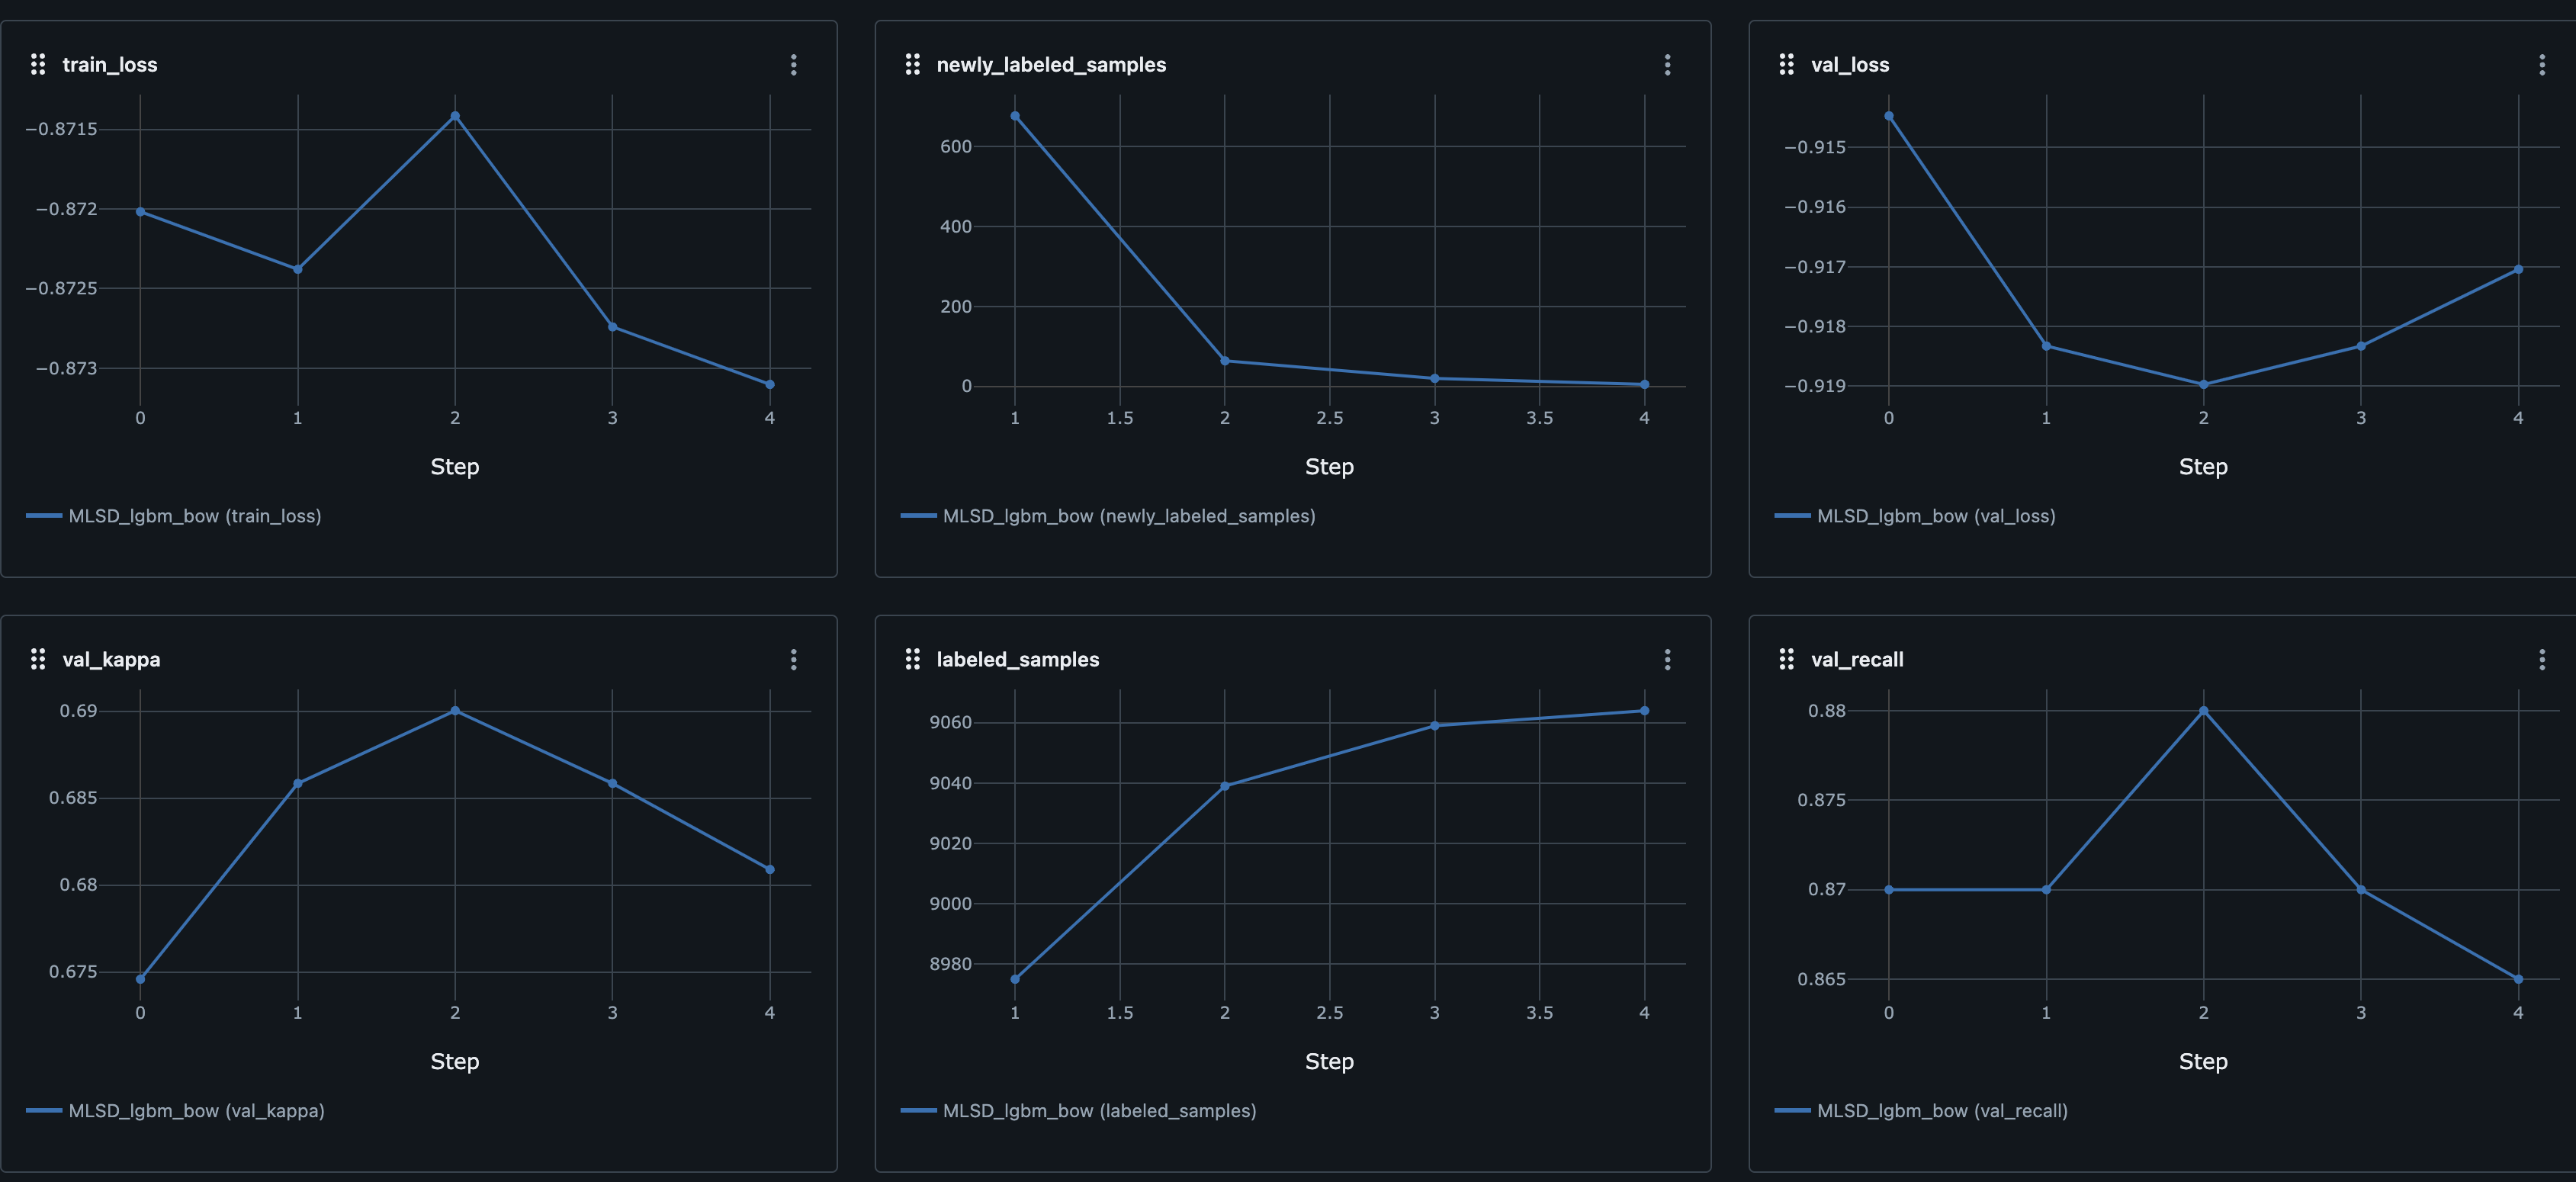

## LSTM

In [19]:
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset, default_collate

In [46]:
class LightningSelfTrainingClassifier(pl.LightningModule):
    def __init__(self, model, labeled_dataset, unlabeled_dataset,
                 val_dataset=None, metric_functions=None,
                 confidence_threshold=0.75, pseudo_label_batch_size=1000,
                 collate_fn=default_collate, lr=1e-4, batch_size=16):
        super().__init__()
        self.model = model
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.val_dataset = val_dataset
        self.pseudo_labeled_dataset = []
        self.metric_functions = metric_functions
        self.confidence_threshold = confidence_threshold
        self.pseudo_label_batch_size = pseudo_label_batch_size
        self.collate_fn = collate_fn
        self.lr = lr
        self.batch_size = batch_size
    
    def forward(self, x):
        return self.model.forward(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        for name, func in (self.metric_functions or {}).items():
            score = func(y.detach().cpu().numpy(), (y_hat[:, 1] >= 0.5).to(int).detach().cpu().numpy().ravel())
            self.log(f"train_{name}", score, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True)
        for name, func in (self.metric_functions or {}).items():
            score = func(y.detach().cpu().numpy(), (y_hat[:, 1] >= 0.5).to(int).detach().cpu().numpy().ravel())
            self.log(f"val_{name}", score, on_epoch=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        if len(self.pseudo_labeled_dataset) > 0:
            combined_dataset = ConcatDataset([self.labeled_dataset] + self.pseudo_labeled_dataset)
        else:
            combined_dataset = self.labeled_dataset
            
        return DataLoader(combined_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)
        
    def generate_pseudo_labels(self):
        self.model.eval()
        pseudo_dataset = []

        remaining_unlabeled = self.unlabeled_dataset
        
        with torch.inference_mode():
            dataloader = DataLoader(remaining_unlabeled, batch_size=self.pseudo_label_batch_size, collate_fn=self.collate_fn)
            
            for batch in dataloader:
                x, _ = batch
                outputs = self.model(x.to("cuda:0"))
                probabilities = F.softmax(outputs, dim=1)
                max_probs, pseudo_labels = torch.max(probabilities, dim=1)
                
                confident_indices = torch.where(max_probs >= self.confidence_threshold)[0].cpu()
                
                if len(confident_indices) > 0:
                    confident_x = x[confident_indices]
                    confident_pseudo_labels = pseudo_labels[confident_indices]
                    
                    confident_dataset = TensorDataset(confident_x, confident_pseudo_labels)
                    pseudo_dataset.append(confident_dataset)
                    
        if pseudo_dataset:
            self.pseudo_labeled_dataset.append(ConcatDataset(pseudo_dataset))
            self.log('pseudo_labeled_count', len(self.pseudo_labeled_dataset[-1]), logger=True)
            return True
        return False

class PseudoLabelingCallback(pl.Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        if not pl_module.generate_pseudo_labels() and trainer.current_epoch > 0:
            trainer.should_stop = True

class LabeledDataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]

class UnlabeledDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], -1
    
@torch.inference_mode()
def evaluate_metrics_torch(model, val_loader, metric_fns):
    val_results = []
    real_labels = []
    out = {}
    for x, y in val_loader:
        real_labels.extend(y.numpy().tolist())
        val_results.extend((model.forward(x.to("cuda:0"))[:, 1] >= 0.5).to(int).cpu().numpy().tolist())
    for name, func in (metric_fns or {}).items():
        out[name] = func(real_labels, val_results)
    return out

In [21]:
from sentencepiece import SentencePieceProcessor, SentencePieceTrainer
with open("spm_input.txt", "w") as f:
    f.writelines(map(lambda x: x + "\n", data_train.loc[:, "Message"].tolist()))
SentencePieceTrainer.train('--input=spm_input.txt --model_prefix=my_model --character_coverage=0.99 --model_type=unigram')
sp = SentencePieceProcessor()
sp.load('my_model.model')

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=spm_input.txt --model_prefix=my_model --character_coverage=0.99 --model_type=unigram
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: spm_input.txt
  input_format: 
  model_prefix: my_model
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.99
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id

True

terface.cc(425) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(430) LOG(INFO) Normalizing sentences...
trainer_interface.cc(539) LOG(INFO) all chars count=3047884
trainer_interface.cc(550) LOG(INFO) Done: 99.165% characters are covered.
trainer_interface.cc(560) LOG(INFO) Alphabet size=31
trainer_interface.cc(561) LOG(INFO) Final character coverage=0.99165
trainer_interface.cc(592) LOG(INFO) Done! preprocessed 49655 sentences.
unigram_model_trainer.cc(265) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(269) LOG(INFO) Extracting frequent sub strings... node_num=1727510
unigram_model_trainer.cc(312) LOG(INFO) Initialized 78834 seed sentencepieces
trainer_interface.cc(598) LOG(INFO) Tokenizing input sentences with whitespace: 49655
trainer_interface.cc(609) LOG(INFO) Done! 40371
unigram_model_trainer.cc(602) LOG(INFO) Using 40371 sentences for EM training
unigram_model_trainer.cc(618) LOG(INFO) EM sub_iter=0 siz

In [22]:
def sentencepiece_collate_fn(batch, sp_processor,
                            pad_token_id=0,) -> torch.Tensor:
    texts, labels = zip(*batch)
    encoded_inputs = [sp_processor.encode_as_ids(text) for text in texts]
    
    max_length = max(len(ids) for ids in encoded_inputs)
    
    batch_size = len(batch)
    input_ids = np.full((batch_size, max_length), pad_token_id, dtype=np.int64)
    
    for i, encoded_input in enumerate(encoded_inputs):        
        seq_length = len(encoded_input)
        input_ids[i, :seq_length] = encoded_input
    
    return torch.tensor(input_ids, dtype=torch.long), torch.tensor(labels)


In [23]:
class ProbLSTM(nn.Module):
    def __init__(self, max_vocab, hid_dim=256):
        super().__init__()
        self.emb = nn.Embedding(max_vocab, hid_dim, padding_idx=-1)
        self.lstm = nn.LSTM(hid_dim, hid_dim, 2, batch_first=True, dropout=0.1, bidirectional=True)
        self.lin = nn.Linear(4 * hid_dim, 2)

    def forward(self, x):
        emb = self.emb(x)
        out, (h, c) = self.lstm(emb)
        h = torch.flatten(h.transpose(1, 0), start_dim=1)
        return self.lin(h)

In [45]:
import os
import random
import torch.backends.cudnn as cudnn

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    torch.use_deterministic_algorithms(True, warn_only=True)
    
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
from functools import partial
from pytorch_lightning.loggers.mlflow import MLFlowLogger

data_labeled = data_train.loc[~data_train.Category.isna()].Message.tolist()
data_unlabeled = data_train.loc[data_train.Category.isna()].Message.tolist()

metric_fns = {
    "kappa": cohen_kappa_score,
    "MCC": matthews_corrcoef,
    "f1": f1_score,
    "recall": recall_score,
    "precision": precision_score,
    "accuracy": accuracy_score
}

set_seed(42)

clf = LightningSelfTrainingClassifier(
    ProbLSTM(sp.vocab_size()).to("cuda:0"), LabeledDataset(data_labeled, y_train.tolist()), UnlabeledDataset(data_unlabeled),
    LabeledDataset(data_val.Message.tolist(), y_val.tolist()), metric_fns, collate_fn=partial(sentencepiece_collate_fn, sp_processor=sp),
    confidence_threshold=0.9, lr=5e-5
)

trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[PseudoLabelingCallback()],
    logger=MLFlowLogger(run_name="MLSD_LSTM")
)

trainer.fit(clf)

for name, score in evaluate_metrics_torch(
        clf.model.to("cuda:0").eval(),
        DataLoader(LabeledDataset(data_val.Message.tolist(), y_val.tolist()), collate_fn=partial(sentencepiece_collate_fn, sp_processor=sp)),
        metric_fns
    ):
    print(f"{name}={score}")

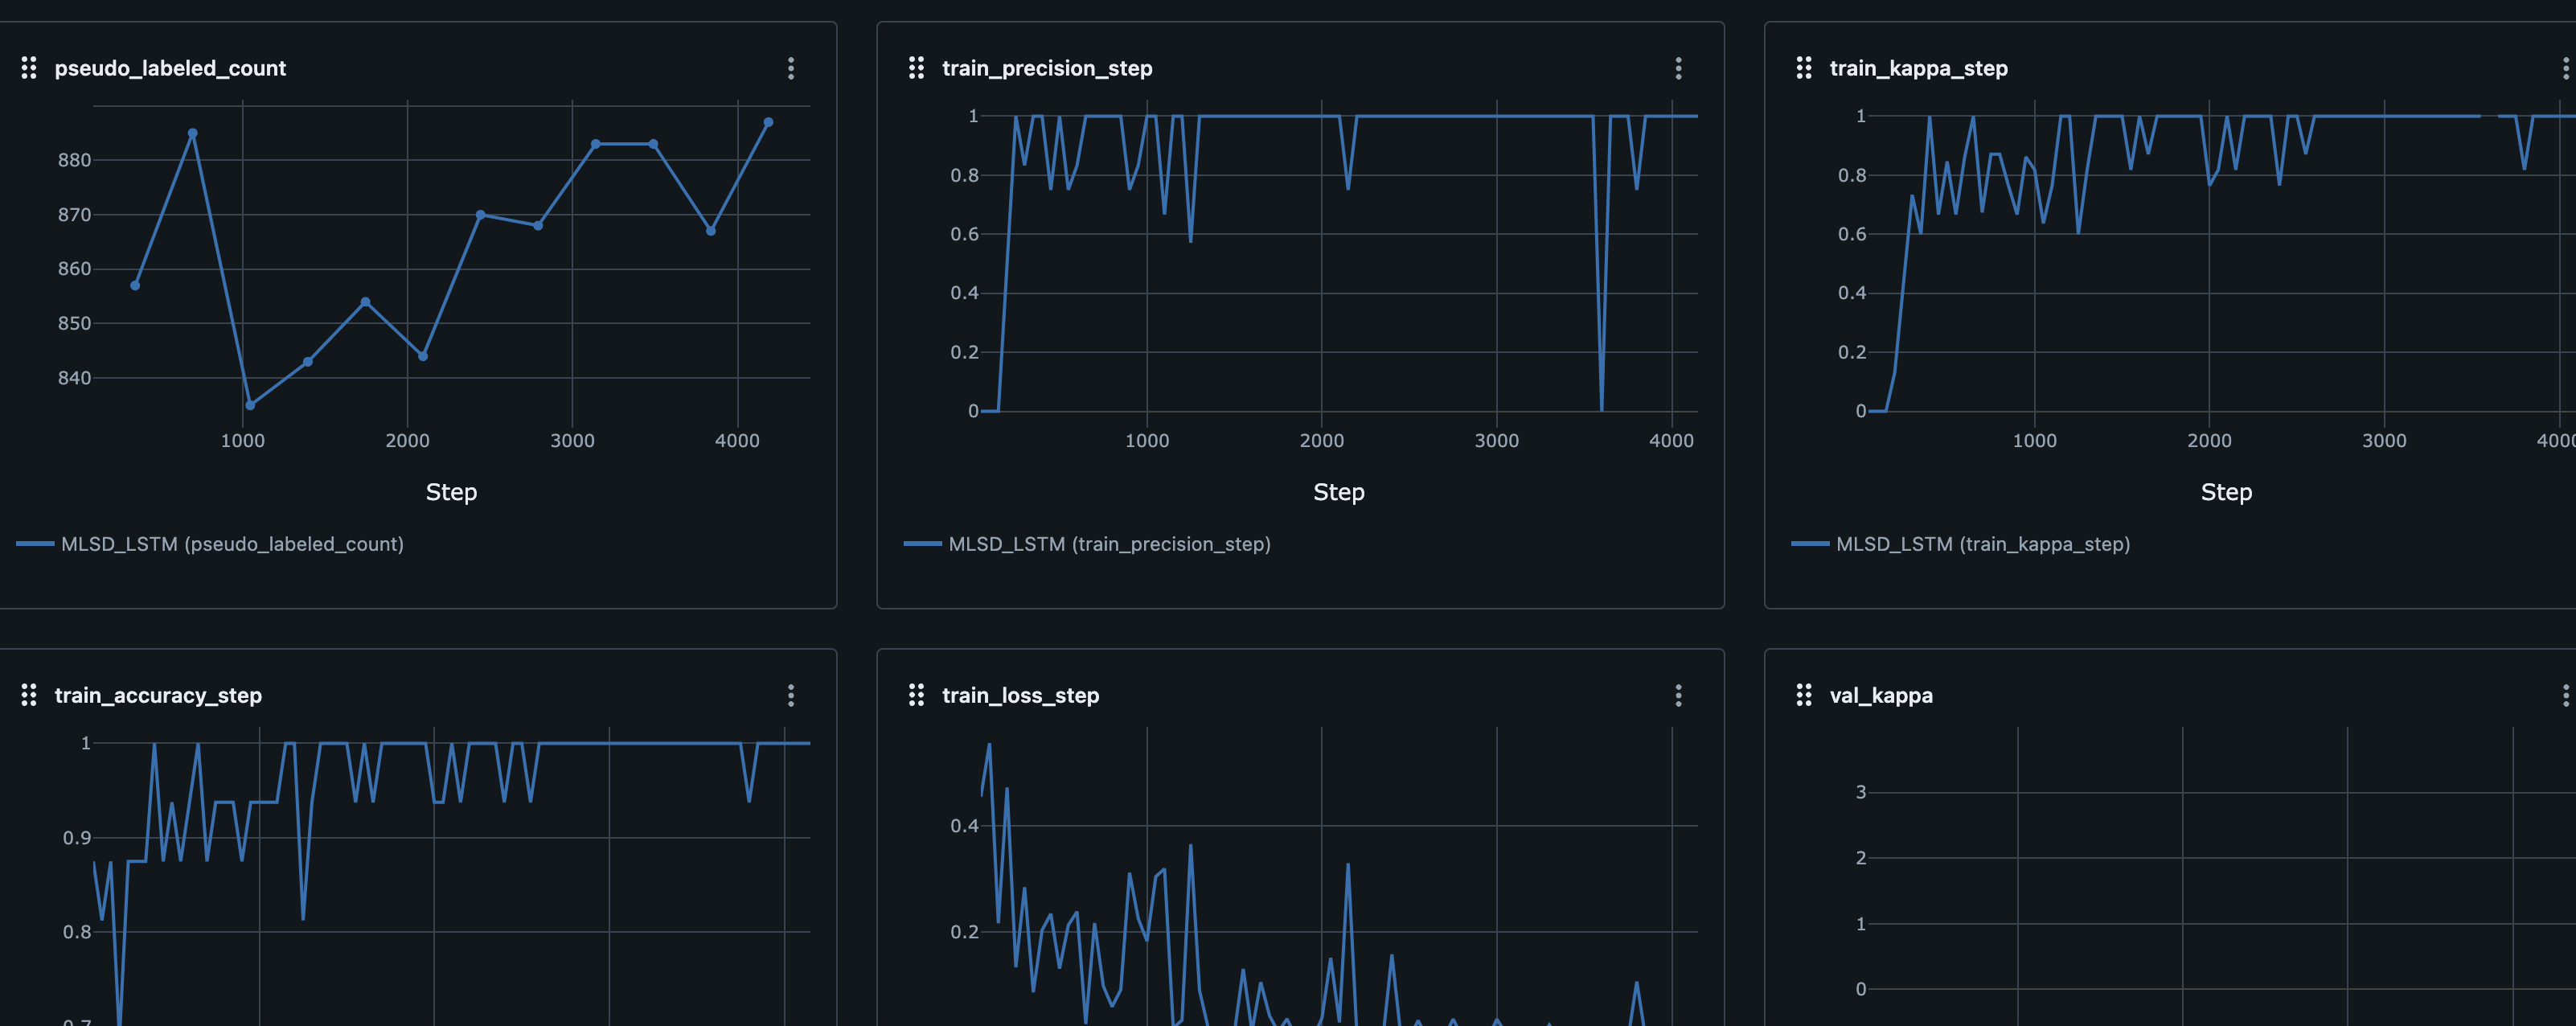

## catboost

In [26]:
data_train.loc[:, ["Message"]].astype(str)

,Message
3154,i tagged my friends that you seemed to count a...
2639,am in gobi arts college
4089,he needs to stop going to bed and make with th...
1482,im a guy browsin is compulsory
4101,i not at home now lei
...,...
1080,kumar kumari kumbh mela is one of the most imp...
1081,it again not going to let you get away with th...
1082,pic twitter com hf matthew mccoy april the tw...
1083,sent via blackberry by at t


In [27]:
from catboost import CatBoostClassifier

clf = MLflowTrackingSelfTrainingClassifier(CatBoostClassifier(
    random_state=42, verbose=0,
    text_features=[0]
), run_name="MLSD_catboost_text")

clf.fit(
    data_train.loc[:, ["Message"]].astype(str), y_train.fillna(-1),
    data_val.loc[:, ["Message"]].astype(str), y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_text = clf.predict(data_val.loc[:, ["Message"]].astype(str))

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_text.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_text)}\n"
    f"f1: {f1_score(y_val, y_pred_text)}\n"
    f"recall: {recall_score(y_val, y_pred_text)}\n"
    f"precision: {precision_score(y_val, y_pred_text)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_text)}\n"
)

kappa (MAIN): 0.8753042099864795
MCC: 0.8753962346389578
f1: 0.8911392405063291
recall: 0.88
precision: 0.9025641025641026
accuracy: 0.9723472668810289



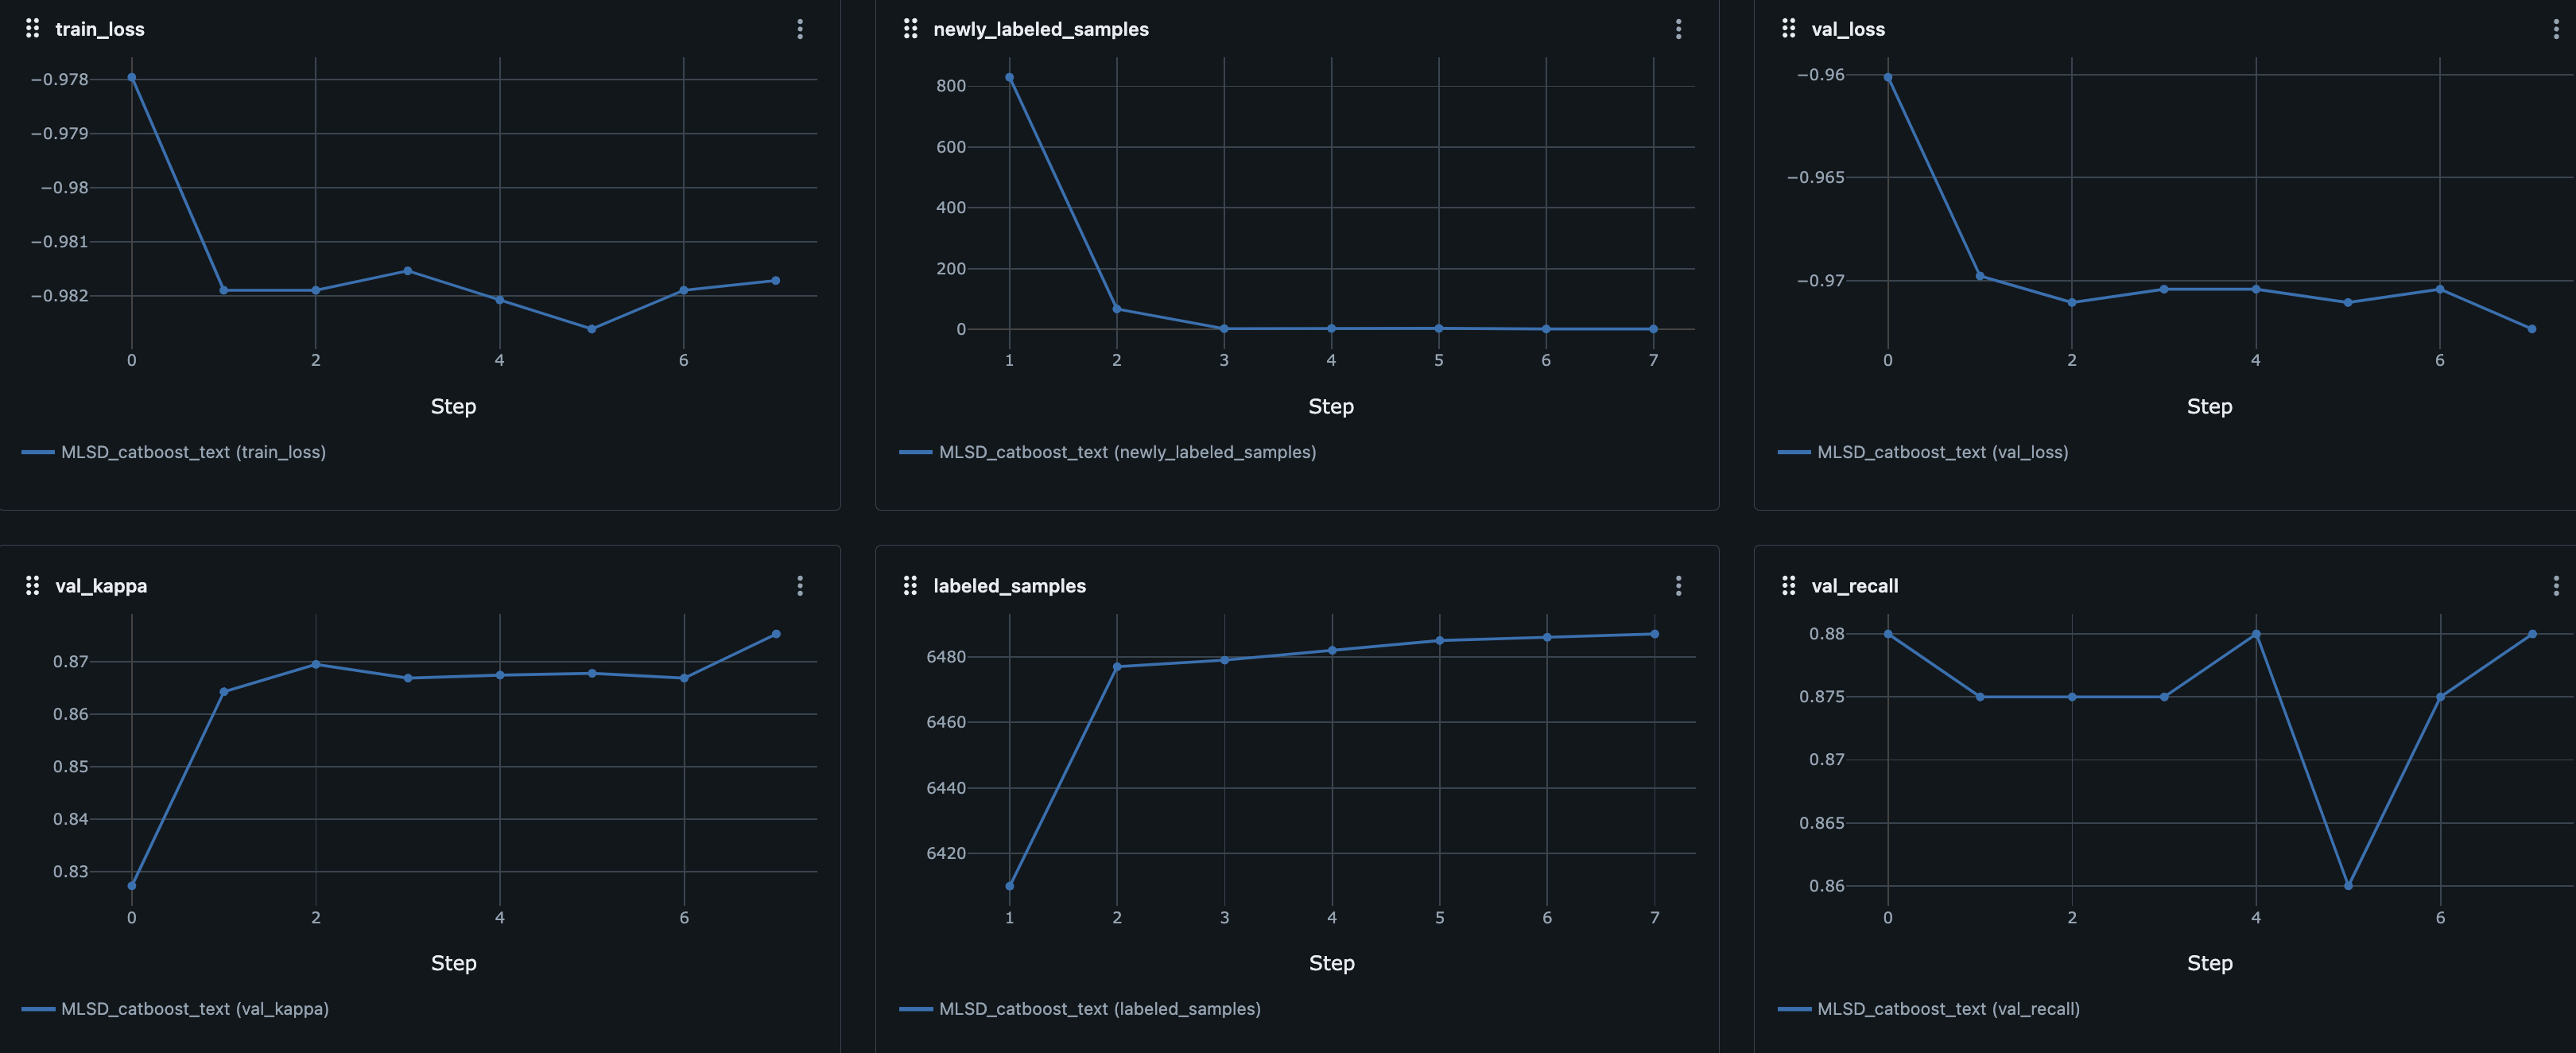

## Bert

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased").bert

embedder = bert.embeddings.to("cuda:0")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from tqdm import tqdm


bert_train = []
bert_val = []

with torch.no_grad():
    for text in tqdm(data_train.Message.values):
        bert_train.append(embedder(tokenizer.encode(text, return_tensors="pt", max_length=50, truncation=True, padding="max_length").to("cuda:0")).cpu())
    for text in tqdm(data_val.Message.values):
        bert_val.append(embedder(tokenizer.encode(text, return_tensors="pt", max_length=50, truncation=True, padding="max_length").to("cuda:0")).cpu())

bert_train = torch.cat(bert_train, dim=0)
bert_val = torch.cat(bert_val, dim=0)

100%|██████████| 1555/1555 [00:01<00:00, 816.11it/s]


In [30]:
bert_train_labeled = bert_train[known_indices.values]
bert_train_unlabeled = bert_train[~known_indices.values]

In [31]:
class BertCLF(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased").bert.encoder
        for layer in self.encoder.layer[:-1]:
            for p in layer.parameters():
                p.requires_grad_(False)
        for p in self.encoder.layer[-1].attention.parameters():
            p.requires_grad_(False)
        for p in self.encoder.layer[-1].intermediate.parameters():
            p.requires_grad_(False)
        self.fc = nn.Linear(768, 2)
    
    def forward(self, x):
        x = self.encoder(x).last_hidden_state
        x = x.mean(-2)
        return self.fc(x)

In [32]:
set_seed(42)

clf = LightningSelfTrainingClassifier(
    BertCLF().to("cuda:0"), LabeledDataset(bert_train_labeled, y_train.tolist()), UnlabeledDataset(bert_train_unlabeled),
    LabeledDataset(bert_val, y_val.tolist()), metric_fns, lr=1e-4, batch_size=4
)

trainer = pl.Trainer(
    max_epochs=7,
    callbacks=[PseudoLabelingCallback()],
    logger=MLFlowLogger(run_name="MLSD_Bert")
)

trainer.fit(clf)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | BertCLF | 85.1 M | train
------------------------------------------
2.4 M     Trainable params
82.7 M    Non-trainable params
85.1 M    Total params
3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.


In [ ]:
for name, score in evaluate_metrics_torch(
        clf.model.to("cuda:0").eval(),
        DataLoader(LabeledDataset(bert_val, y_val.tolist())),
        metric_fns
    ):
    print(f"{name} = {score}")

kappa =  0.9073078808972128
MCC =  0.9087756135423777
f1 =  0.9186351706036745
recall =  0.875
precision =  0.9668508287292817
accuracy =  0.980064308681672


## Гиперпараметры

### RandomSearch
Так как одна из моделей -- нейронка (не самая маленькая), да и катбуст учится не мгновенно, то подбор гиперпараметров будем проводить по отложенной выборке (не кроссвалидацией)

In [34]:
indices_train, indices_val = train_test_split(
    range(len(data_labeled)), test_size=0.3,
    random_state=42, stratify=y_train.dropna().values
)

y_hyperopt_train, y_hyperopt_val = y_train.iloc[indices_train], y_train.iloc[indices_val]

catboost_hyperopt_train = np.array(data_labeled)[indices_train]
catboost_hyperopt_val = np.array(data_labeled)[indices_val]

bert_hyperopt_train = bert_train_labeled[indices_train]
bert_hyperopt_val = bert_train_labeled[indices_val]

In [54]:
random_search_grid = {
    "confidence_threshold": [ 0.75, 0.8, 0.9, 0.95],
    "n_epochs": [2, 3, 5, 7]
}

In [ ]:
from copy import deepcopy


params_to_kappa = {}
best_model = None
best_kappa = 0
with mlflow.start_run(run_name="catboost_random_search", nested=True) as parent_run:
    for _ in tqdm(range(7)):
        while True:
            thresh = np.random.choice(random_search_grid["confidence_threshold"])
            n_epochs = np.random.choice(random_search_grid["n_epochs"])
            if (thresh, n_epochs) not in params_to_kappa.keys():
                break
        clf = MLflowTrackingSelfTrainingClassifier(CatBoostClassifier(
            random_state=42, verbose=0,
            text_features=[0]
        ), run_name=f"catboost_random_search_thresh_{thresh}_epochs_{n_epochs}",
        threshold=thresh, max_iter=n_epochs)

        clf.fit(
            np.concatenate((catboost_hyperopt_train, data_unlabeled)).reshape(-1, 1),
            np.array(y_hyperopt_train.tolist() + [-1] * len(data_unlabeled)),
            catboost_hyperopt_val.reshape(-1, 1), y_hyperopt_val.values.astype(int),
            {
                "kappa": cohen_kappa_score,
                "MCC": matthews_corrcoef,
                "f1": f1_score,
                "recall": recall_score,
                "precision": precision_score,
                "accuracy": accuracy_score
            }
        )
        y_pred_text = clf.predict(catboost_hyperopt_val.reshape(-1, 1))

        curr_kappa = cohen_kappa_score(y_hyperopt_val.astype(int), y_pred_text.ravel())
        params_to_kappa[(thresh, n_epochs)] = curr_kappa
        if curr_kappa > best_kappa:
            best_kappa = curr_kappa
            best_model = deepcopy(clf)
        print(f"{best_kappa=}, {curr_kappa=}, {thresh=}, {n_epochs=}")

y_pred_text = best_model.predict(data_val.loc[:, ["Message"]].astype(str))

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_text.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_text)}\n"
    f"f1: {f1_score(y_val, y_pred_text)}\n"
    f"recall: {recall_score(y_val, y_pred_text)}\n"
    f"precision: {precision_score(y_val, y_pred_text)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_text)}\n"
)

 14%|█▍        | 1/7 [03:50<23:04, 230.73s/it]

best_kappa=0.8977576127737544, curr_kappa=0.8977576127737544, thresh=0.9, n_epochs=3


 29%|██▊       | 2/7 [08:48<22:30, 270.07s/it]

best_kappa=0.8977576127737544, curr_kappa=0.8945118227030799, thresh=0.8, n_epochs=12


 43%|████▎     | 3/7 [12:43<16:56, 254.01s/it]

best_kappa=0.8977576127737544, curr_kappa=0.894678460046345, thresh=0.95, n_epochs=3


 57%|█████▋    | 4/7 [17:36<13:28, 269.45s/it]

best_kappa=0.8977576127737544, curr_kappa=0.8945118227030799, thresh=0.8, n_epochs=10


 71%|███████▏  | 5/7 [19:34<07:09, 214.97s/it]

best_kappa=0.8977576127737544, curr_kappa=0.8962168194314477, thresh=0.5, n_epochs=7


 86%|████████▌ | 6/7 [22:44<03:26, 206.45s/it]

best_kappa=0.8977576127737544, curr_kappa=0.8962168194314477, thresh=0.6, n_epochs=12


100%|██████████| 7/7 [28:49<00:00, 247.05s/it]

best_kappa=0.8977576127737544, curr_kappa=0.8960524860431135, thresh=0.9, n_epochs=7
kappa (MAIN): 0.8817108190860163
MCC: 0.8824674447296442
f1: 0.8963730569948186
recall: 0.865
precision: 0.9301075268817204
accuracy: 0.9742765273311897



In [ ]:
params_to_kappa = {}
best_model = None
best_kappa = 0

set_seed(0)

with mlflow.start_run(run_name="Bert_random_search", nested=True) as parent_run:
    for _ in tqdm(range(7)):
        while True:
            thresh = np.random.choice(random_search_grid["confidence_threshold"])
            n_epochs = np.random.choice(random_search_grid["n_epochs"])
            if (thresh, n_epochs) not in params_to_kappa.keys():
                break
        clf = LightningSelfTrainingClassifier(
            BertCLF().to("cuda:0"), LabeledDataset(bert_hyperopt_train, y_hyperopt_train.tolist()), UnlabeledDataset(bert_train_unlabeled),
            LabeledDataset(bert_hyperopt_val, y_hyperopt_val.values.astype(int)), metric_fns, lr=1e-4, batch_size=4, confidence_threshold=thresh
        )
        trainer = pl.Trainer(
            max_epochs=int(n_epochs),
            callbacks=[PseudoLabelingCallback()],
            logger=MLFlowLogger(run_name=f"MLSD_Bert_{thresh=}_{n_epochs=}")
        )
        trainer.fit(clf)
        
        curr_kappa = evaluate_metrics_torch(
            clf.model.to("cuda:0").eval(),
            DataLoader(LabeledDataset(bert_hyperopt_val, y_hyperopt_val.values.astype(int))),
            {"kappa": cohen_kappa_score}
        )["kappa"]
        params_to_kappa[(thresh, n_epochs)] = curr_kappa
        if curr_kappa > best_kappa:
            best_kappa = curr_kappa
            best_model = deepcopy(clf)
        print(f"{best_kappa=}, {curr_kappa=}, {thresh=}, {n_epochs=}")

for name, score in evaluate_metrics_torch(
        best_model.model.to("cuda:0").eval(),
        DataLoader(LabeledDataset(bert_val, y_val.tolist())),
        metric_fns
    ).items():
    print(f"{name} = {score}")

kappa = 0.907002822060665
MCC = 0.9071407396873016
f1 = 0.9187817258883249
recall = 0.905
precision = 0.9329896907216495
accuracy = 0.9794212218649517


In [ ]:
params_to_kappa # (там умерло на инференсе, но остались логи и вот это)

{(0.75, 7): 0.9079831000972369,
 (0.8, 2): 0.8233618233618234,
 (0.95, 7): 0.8713843065629541,
 (0.8, 7): 0.8554701986754967,
 (0.8, 5): 0.8670277998965423,
 (0.9, 2): 0.8112165680902352,
 (0.75, 2): 0.8513759534499816}

Фиксируем для катбуста thresh = 0.9, n_epochs = 3

Для берта -- thresh = 0.75, n_epochs = 7

### Bayes optimization

In [ ]:
import optuna

def catboost_objective(trial):
    depth = trial.suggest_int('depth', 1, 12)
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 0.1, log=True)
    iterations = trial.suggest_int('iterations', 100, 2000)

    clf = MLflowTrackingSelfTrainingClassifier(CatBoostClassifier(
        random_state=42, verbose=0,
        text_features=[0], learning_rate=learning_rate,
        depth=depth, iterations=iterations
    ), run_name=f"catboost_random_search_lr_{learning_rate}_depth_{depth}",
    threshold=0.9, max_iter=3)

    clf.fit(
        np.concatenate((catboost_hyperopt_train, data_unlabeled)).reshape(-1, 1),
        np.array(y_hyperopt_train.tolist() + [-1] * len(data_unlabeled)),
        catboost_hyperopt_val.reshape(-1, 1), y_hyperopt_val.values.astype(int),
        {
            "kappa": cohen_kappa_score,
            "MCC": matthews_corrcoef,
            "f1": f1_score,
            "recall": recall_score,
            "precision": precision_score,
            "accuracy": accuracy_score
        }
    )
    y_pred_text = clf.predict(catboost_hyperopt_val.reshape(-1, 1))

    curr_kappa = cohen_kappa_score(y_hyperopt_val.astype(int), y_pred_text.ravel())
    
    mlflow.log_metric("cohen_kappa", curr_kappa)
    
    return curr_kappa

with mlflow.start_run(run_name="MLSD_optuna_catboost_bayes_optuna"):
    study = optuna.create_study(direction="maximize")
    study.optimize(catboost_objective, n_trials=7)

In [ ]:
clf = MLflowTrackingSelfTrainingClassifier(CatBoostClassifier(
    random_state=42, verbose=0,
    text_features=[0]
), run_name=f"restart_1",
threshold=0.9, max_iter=3)

clf.fit(
    np.concatenate((catboost_hyperopt_train, data_unlabeled)).reshape(-1, 1),
    np.array(y_hyperopt_train.tolist() + [-1] * len(data_unlabeled)),
    catboost_hyperopt_val.reshape(-1, 1), y_hyperopt_val.values.astype(int),
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)
y_pred_text = clf.predict(data_val.loc[:, ["Message"]].astype(str))
print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_text.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_text)}\n"
    f"f1: {f1_score(y_val, y_pred_text)}\n"
    f"recall: {recall_score(y_val, y_pred_text)}\n"
    f"precision: {precision_score(y_val, y_pred_text)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_text)}\n"
)

kappa (MAIN): 0.8971745434965378
MCC: 0.8976433977431272
f1: 0.910025706940874
recall: 0.885
precision: 0.9365079365079365
accuracy: 0.977491961414791



AttributeError: 'MLflowTrackingSelfTrainingClassifier' object has no attribute 'model'

In [ ]:
clf.estimator_.save_model('sms_spam_catboost_model.cbm')

In [63]:
def bert_objective_bayes(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8])
    

    clf = LightningSelfTrainingClassifier(
        BertCLF().to("cuda:0"), LabeledDataset(bert_hyperopt_train, y_hyperopt_train.tolist()), UnlabeledDataset(bert_train_unlabeled),
        LabeledDataset(bert_hyperopt_val, y_hyperopt_val.values.astype(int)), metric_fns, lr=learning_rate, batch_size=batch_size,
        confidence_threshold=0.75
    )
    trainer = pl.Trainer(
        max_epochs=7,
        callbacks=[PseudoLabelingCallback()],
        logger=MLFlowLogger(run_name=f"MLSD_Bert_{learning_rate=}_{batch_size=}")
    )
    trainer.fit(clf)
    
    curr_kappa = evaluate_metrics_torch(
        clf.model.to("cuda:0").eval(),
        DataLoader(LabeledDataset(bert_hyperopt_val, y_hyperopt_val.values.astype(int))),
        {"kappa": cohen_kappa_score}
    )["kappa"]
    return curr_kappa

with mlflow.start_run(run_name="MLSD_optuna_bert"):
    study = optuna.create_study(direction="maximize")
    study.optimize(bert_objective_bayes, n_trials=5)

[I 2025-03-25 19:48:30,362] A new study created in memory with name: no-name-dff7a54d-4c36-49b9-bae0-02898ae932d0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | BertCLF | 85.1 M | train
------------------------------------------
2.4 M     Trainable params
82.7 M    Non-trainable params
85.1 M    Total params
3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.
[I 2025-03-25 20:18:06,594] Trial 0 finished with value: 0.7092467921054146 and parameters: {'learning_rate': 0.002175667597126661, 'batch_size': 2}. Best is trial 0 with value: 0.7092467921054146.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.
[I 2025-03-25 20:27:31,073] Trial 1 finished with value: 0.906056976314148 and parameters: {'learning_rate': 0.000390201510848511, 'batch_size': 8}. Best is trial 1 with value: 0.906056976314148.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.
[I 2025-03-25 20:57:59,792] Trial 2 finished with value: 0.9115531998909918 and parameters: {'learning_rate': 0.007143563150425351, 'batch_size': 2}. Best is trial 2 with value: 0.9115531998909918.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.
[I 2025-03-25 21:14:03,956] Trial 3 finished with value: 0.8380088513925835 and parameters: {'learning_rate': 3.5123718081076374e-05, 'batch_size': 4}. Best is trial 2 with value: 0.9115531998909918.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[W 2025-03-25 21:14:31,518] Trial 4 failed with parameters: {'learning_rate': 1.6258028446591222e-05, 'batch_size': 2} because of the following error: TypeError('expected Tensor as element 1 in argument 0, but got int').
Traceback (most recent call last):
  File "/home/vfyas/anaconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/tmp/ipykernel_1638978/3689561759.py", line 16, in bert_objective_bayes
    trainer.fit(clf)
  File "/home/vfyas/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/trainer.py", line 539, in fit
    call._call_and_handle_interrupt(
  File "/home/vfyas/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vfyas/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/trainer.py"

TypeError: expected Tensor as element 1 in argument 0, but got int

Фиксируем lr=0.007143563150425351, batch_size=2

### Прунинг с использованием многоруких бандитов

In [77]:
pruner = optuna.pruners.SuccessiveHalvingPruner()
study = optuna.create_study(
    direction="maximize",
    pruner=pruner
)

study.optimize(catboost_objective, n_trials=7)

[I 2025-03-25 22:06:27,016] A new study created in memory with name: no-name-eeaffa53-fa87-4f38-9815-3acef3731de9
[I 2025-03-25 22:06:54,181] Trial 0 finished with value: 0.9033146778022283 and parameters: {'depth': 3, 'learning_rate': 0.0003949139141438471, 'iterations': 752}. Best is trial 0 with value: 0.9033146778022283.
[I 2025-03-25 22:08:20,293] Trial 1 finished with value: 0.9033146778022283 and parameters: {'depth': 7, 'learning_rate': 1.426075497769365e-05, 'iterations': 1967}. Best is trial 0 with value: 0.9033146778022283.
[I 2025-03-25 22:09:35,420] Trial 2 finished with value: 0.8825008920058726 and parameters: {'depth': 2, 'learning_rate': 0.0025949210924172007, 'iterations': 1929}. Best is trial 0 with value: 0.9033146778022283.
[I 2025-03-25 22:10:02,029] Trial 3 finished with value: 0.9033146778022283 and parameters: {'depth': 4, 'learning_rate': 8.602516955620624e-06, 'iterations': 1521}. Best is trial 0 with value: 0.9033146778022283.
[I 2025-03-25 22:12:22,065] Tri

In [78]:
clf = MLflowTrackingSelfTrainingClassifier(CatBoostClassifier(
    random_state=42, verbose=0,
    text_features=[0], learning_rate=0.0003949139141438471,
    depth=3
), run_name=f"restart_2",
threshold=0.9, max_iter=3)

clf.fit(
    np.concatenate((catboost_hyperopt_train, data_unlabeled)).reshape(-1, 1),
    np.array(y_hyperopt_train.tolist() + [-1] * len(data_unlabeled)),
    catboost_hyperopt_val.reshape(-1, 1), y_hyperopt_val.values.astype(int),
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)
y_pred_text = clf.predict(data_val.loc[:, ["Message"]].astype(str))
print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_text.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_text)}\n"
    f"f1: {f1_score(y_val, y_pred_text)}\n"
    f"recall: {recall_score(y_val, y_pred_text)}\n"
    f"precision: {precision_score(y_val, y_pred_text)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_text)}\n"
)

kappa (MAIN): 0.8318040570889058
MCC: 0.8318344788520957
f1: 0.8535980148883374
recall: 0.86
precision: 0.8472906403940886
accuracy: 0.9620578778135048



Как бы того ни хотелось, добиться с помощью катбуста качества лучше берта не получилось, но выберем все равно его, потому что разница в качестве не такая большая (0.897 vs 0.9), а использовать катбуст в этой задаче лучше по причине большей скорости и меньших требований на ресурсы (не нужна гпу на стороне пользователя (в целом это главная причина, я забыл, что у нас не сервер, а демка на устройстве, а гонять берт на цпу не хочу совсем))

Для подбора гиперпараметров слишком много логов, я в них запутался, а перезапустить не успею, я закинул их сюда: https://drive.google.com/drive/folders/12jfEMHzan-jITaSWimnVjQvWrGBNI_Wl?usp=sharing